# Utils for Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 4.1 MB/s 


# Utils

In [ ]:
# Importing Library
import pywt
import time
import imblearn
import numpy as np
import keras_tuner
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt

# Importing module
from scipy import stats
from datetime import datetime
from collections import Counter
from imblearn.over_sampling import SMOTE

# Importing Sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Importing Tensorflow and Keras Module
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

from keras.models import load_model
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.layers import  Activation, Conv1D, Conv2D, Dense,\
     MaxPooling1D, Flatten, BatchNormalization, GRU, Input, Dropout,\
     MaxPooling2D, concatenate

print("Done Importing Package")

Done Importing Package


# Class PREPROCESSING

In [ ]:
class PREPROCESSING():
  def __init__(self):
    self.x_file     = []
    self.y_file     = []
    self.x_train    = None
    self.x_test     = None
    self.y_train    = None
    self.y_test     = None
    self.sum_data   = None
    self.len_data   = None
    self.depth_data = None

  def collect_data(self, no_file, database):
    self.x_file     = []
    self.y_file     = []
    for i in range(no_file):
      data = pd.read_csv(f"Sleep_Stage_Identification/Dataset{database}/Data_EEG_s{i}.txt", delimiter=";", header=None).dropna()
      # data = pd.read_csv(f"/content/gdrive/MyDrive/Dataset/Dataset{database}/Data_EEG_s{i}.txt", delimiter=";", header=None).dropna()
      x_col = data.iloc[:, 1:3001].to_numpy()
      y_col = data.iloc[:, 3001].to_numpy()
      for j in range(len(data)):
        self.x_file.append(x_col[j])
        self.y_file.append(y_col[j])

    self.x_file = np.array(self.x_file)
    self.y_file = np.reshape(self.y_file, (-1, 1))
    print(f"Length of signal data : {self.x_file.shape}")

  def collect_data_train(self):
    data = pd.read_csv(f"Sleep_Stage_Identification/TrainDataset/TrainingDataset.txt", delimiter=";", header=None).dropna()
    x_col = data.iloc[:,:3000].to_numpy()
    y_col = data.iloc[:, 3000].to_numpy()
    self.x_file = np.array(x_col)
    self.y_file = np.reshape(y_col, (-1, 1))
    print(f"Length of signal data : {self.x_file.shape}")

  def collect_data_test(self):
    data = pd.read_csv(f"Sleep_Stage_Identification/TestDataset/TestingDataset.txt", delimiter=";", header=None).dropna()
    x_col = data.iloc[:,:3000].to_numpy()
    y_col = data.iloc[:, 3000].to_numpy()
    self.x_file = np.array(x_col)
    self.y_file = np.reshape(y_col, (-1, 1))
    print(f"Length of signal data : {self.x_file.shape}")

  def filter_signal(self, raw_freq, low, high):
    self.x_file = mne.filter.filter_data(self.x_file, raw_freq, low, high)
    print(self.x_file.shape)

  def smote(self):
    counter = Counter(self.y_file.flatten())
    print(f"Number of Each classes before SMOTE : {counter}")
    oversample = SMOTE()
    self.x_file, self.y_file = oversample.fit_resample(self.x_file, self.y_file)
    self.y_file= np.reshape(self.y_file, (-1, 1))
    counter = Counter(self.y_file.flatten())
    print(f"Number of Each classes after SMOTE  : {counter}")

  def wavelet(self, fams):
    wp = pywt.WaveletPacket2D(data=self.x_file, wavelet=fams, mode='zero')
    scaler = MinMaxScaler(feature_range=(-1,1))

    w_1 = wp['addd'].data
    w_2 = wp['daaa'].data
    w_3 = wp['daad'].data
    w_4 = wp['dada'].data
    w_5 = wp['dadd'].data
    w_6 = wp['ddaa'].data
    w = np.concatenate((w_1,w_2,w_3,w_4,w_5,w_6), axis=0)
    w=scaler.fit_transform(w)

    n1_1 = wp['aadd'].data
    n1_2 = wp['adaa'].data
    n1_3 = wp['adad'].data
    n1_4 = wp['adda'].data
    n1 = np.concatenate((n1_1,n1_2, n1_3,n1_4), axis=0)
    n1=scaler.fit_transform(n1)

    n2_1 = wp['dada'].data
    n2_2 = wp['dadd'].data
    n2_3 = wp['ddaa'].data
    n2_4 = wp['ddad'].data
    n2_5 = wp['ddda'].data
    n2_6 = wp['dddd'].data
    n2 = np.concatenate((n2_1,n2_2,n2_3,n2_4,n2_5,n2_6), axis=0)
    n2=scaler.fit_transform(n2)

    n3_1 = wp['aaaa'].data
    n3_2 = wp['aaad'].data
    n3 = np.concatenate((n3_1,n3_2), axis=0)
    n3=scaler.fit_transform(n3)

    r_1 = wp['aaad'].data
    r_2 = wp['aada'].data
    r_3 = wp['aadd'].data
    r_4 = wp['adaa'].data
    r_5 = wp['adad'].data
    r = np.concatenate((r_1,r_2,r_3,r_4,r_5), axis=0)
    r=scaler.fit_transform(r)

    w_label = []
    lab_w = [[1] * 1 for i in range(len(w))]
    w_label = np.asarray(lab_w)

    n1_label = []
    lab_n1 = [[2] * 1 for i in range(len(n1))]
    n1_label = np.asarray(lab_n1)

    n2_label = []
    lab_2 = [[3] * 1 for i in range(len(n2))]
    n2_label = np.asarray(lab_2)

    n3_label = []
    lab_3 = [[4] * 1 for i in range(len(n3))]
    n3_label = np.asarray(lab_3)

    r_label = []
    lab_r = [[5] * 1 for i in range(len(r))]
    r_label = np.asarray(lab_r)

    self.x_file = np.concatenate((w,n1, n2, n3, r), axis=0)
    self.y_file = np.concatenate((w_label, n1_label, n2_label, n3_label, r_label), axis=0)

    print(f"X File shape after Wavelet: {self.x_file.shape}")
    print(f"Y File shape after Wavelet: {self.y_file.shape}")

  def scaler_signal(self):
    scaler = MinMaxScaler(feature_range=(-1,1))
    self.x_file=scaler.fit_transform(self.x_file)

  def split_reshape(self, test_size):
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x_file, self.y_file, test_size=test_size, random_state=0)

    self.x_train = self.x_train.reshape(self.x_train.shape[0], self.x_train.shape[1] , 1)
    self.x_test  = self.x_test.reshape(self.x_test.shape[0], self.x_test.shape[1] , 1)

    oneHot = OneHotEncoder(sparse=False)
    self.y_train = oneHot.fit_transform(self.y_train)
    self.y_test = oneHot.fit_transform(self.y_test)

    print(f"X and Y Train Shape after reshaping : {self.x_train.shape}{self.y_train.shape}")
    print(f"X and Y Test Shape after reshaping  : {self.x_test.shape}{self.y_test.shape}")

    self.sum_data   = self.x_train.shape[0]
    self.len_data   = self.x_train.shape[1]
    self.depth_data = self.x_train.shape[2]


# Class PREPARE_DATA


In [ ]:
class PREPARE_DATA():
  def __init__(self):
    self.x_train      = None
    self.x_test       = None
    self.y_train      = None
    self.y_test       = None
    self.height_data  = None
    self.len_data     = None
    self.depth_data   = None
    self.TESTING_SIZE = 0.3
    self.WAVELET      = 'db9' # Wavelet family
    self.pre          = PREPROCESSING()

  def prepro_wavelet_datatrain(self):
    start_time = time.time()
    print(f"Start Pre-Proccessing :{datetime.now()}")

    # Pre-processing
    self.pre.collect_data_train()  # Collect data train
    self.pre.wavelet(self.WAVELET)  # Wavelet
    self.pre.smote() # Smote
    self.pre.split_reshape(self.TESTING_SIZE)
    self.x_train, sDelf.x_test, self.y_train, self.y_test, self.len_data, self.depth_data = self.pre.x_train, self.pre.x_test, self.pre.y_train, self.pre.y_test, self.pre.len_data, self.pre.depth_data

    print(f"Finish Pre-Proccessing :{datetime.now()}")
    print(f"Duration of execution  :{time.time() - start_time} seconds")
  
  def prepro_wavelet_datatest(self):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    # Pre-processing
    self.pre.collect_data_test()  # Collect data train
    self.pre.wavelet(self.WAVELET)  # Wavelet
    self.pre.smote() # Smote
    oneHot = OneHotEncoder(sparse=False)
    self.y_test = oneHot.fit_transform(self.pre.y_file)
    self.x_test = self.pre.x_file

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")
  
  def prepro_datatrain(self):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    # Pre-processing
    self.pre.collect_data_train()  # Collect data train
    self.pre.scaler_signal()  # Minmax Scaler
    self.pre.split_reshape(self.TESTING_SIZE)
    self.x_train, self.x_test, self.y_train, self.y_test, self.len_data, self.depth_data = self.pre.x_train, self.pre.x_test, self.pre.y_train, self.pre.y_test, self.pre.len_data, self.pre.depth_data

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")
  
  def prepro_datatest(self):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    # Pre-processing
    self.pre.collect_data_test()  # Collect data train
    self.pre.scaler_signal()
    oneHot = OneHotEncoder(sparse=False)
    self.y_test = oneHot.fit_transform(self.pre.y_file)
    self.x_test = self.pre.x_file

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")
  
  def prepro_wavelet_datafile(self, NUMBER_OF_FILE, NO_DATABASE):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    ## Pre-processing
    self.pre.collect_data(NUMBER_OF_FILE,NO_DATABASE)  ## Collect data file
    self.pre.wavelet(self.WAVELET)  ## Wavelet
    self.pre.smote() # Smote
    self.pre.split_reshape(self.TESTING_SIZE)
    self.x_train, self.x_test, self.y_train, self.y_test, self.len_data, self.depth_data = self.pre.x_train, self.pre.x_test, self.pre.y_train, self.pre.y_test, self.pre.len_data, self.pre.depth_data

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")
  
  def prepro_datafile(self, NUMBER_OF_FILE, NO_DATABASE):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    self.pre.collect_data(NUMBER_OF_FILE,NO_DATABASE)  ## Collect data file
    self.pre.smote() # Smote
    self.pre.scaler_signal()  ## Minmax Scaler
    self.pre.split_reshape(self.TESTING_SIZE)
    self.x_train, self.x_test, self.y_train, self.y_test, self.len_data, self.depth_data = self.pre.x_train, self.pre.x_test, self.pre.y_train, self.pre.y_test, self.pre.len_data, self.pre.depth_data

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")

  def prepro_wavelet_datafile_2D(self, NUMBER_OF_FILE):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    self.pre.collect_data(NUMBER_OF_FILE, 3)
    self.pre.wavelet('coif16')
    self.pre.smote()
    x1_file = self.pre.x_file
    oneHot = OneHotEncoder(sparse=False)
    y_file = oneHot.fit_transform(self.pre.y_file)

    self.pre.collect_data(NUMBER_OF_FILE, 4)
    self.pre.wavelet('coif16')
    self.pre.smote()
    x2_file = self.pre.x_file

    x_file = np.zeros(276)
    for i in range(len(x1_file)):
      x_file = np.vstack((x_file, x1_file[i]))
      x_file = np.vstack((x_file, x2_file[i]))

    x_file = np.delete(x_file, 0, axis=0)
    x_file = np.reshape(x_file,(-1, 24, 23, 1))
    print(f"Size of X and Y File : {x_file.shape} {y_file.shape}")

    mat = int(np.floor(len(x_file)*(1 - self.TESTING_SIZE)))
    print(f"Mat : {mat}")

    self.x_train =  x_file[0:mat]
    self.y_train = y_file[0:mat]
    self.x_test  = x_file[mat:]
    self.y_test  = y_file[mat:]

    self.height_data = self.x_train.shape[1]
    self.len_data    = self.x_train.shape[2]
    self.depth_data  = self.x_train.shape[3]

    print(f"X and Y Train Shape after reshaping : {self.x_train.shape} {self.y_train.shape}")
    print(f"X and Y Test Shape after reshaping  :  {self.x_test.shape} {self.y_test.shape}")

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")

  def prepro_datafile_2D(self, NUMBER_OF_FILE):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    self.pre.collect_data(NUMBER_OF_FILE, 3)
    self.pre.smote()
    x1_file = self.pre.x_file
    oneHot = OneHotEncoder(sparse=False)
    y_file = oneHot.fit_transform(self.pre.y_file)

    self.pre.collect_data(NUMBER_OF_FILE, 4)
    self.pre.smote()
    x2_file = self.pre.x_file

    x_file = np.zeros(3000)
    for i in range(len(x1_file)):
      x_file = np.vstack((x_file, x1_file[i]))
      x_file = np.vstack((x_file, x2_file[i]))

    x_file = np.delete(x_file, 0, axis=0)
    x_file = np.reshape(x_file,(-1, 60, 100, 1))
    print(f"Size of X and Y File : {x_file.shape} {y_file.shape}")

    mat = int(np.floor(len(x_file)*(1 - self.TESTING_SIZE)))
    print(f"Mat : {mat}")

    self.x_train =  x_file[0:mat]
    self.y_train = y_file[0:mat]
    self.x_test  = x_file[mat:]
    self.y_test  = y_file[mat:]

    self.height_data = self.x_train.shape[1]
    self.len_data    = self.x_train.shape[2]
    self.depth_data  = self.x_train.shape[3]

    print(f"X and Y Train Shape after reshaping : {self.x_train.shape} {self.y_train.shape}")
    print(f"X and Y Test Shape after reshaping  :  {self.x_test.shape} {self.y_test.shape}")

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")

# Class MODEL

In [ ]:
class MODEL():
  def __init__(self):
    self.FILTER_1      = 64 
    self.FILTER_2      = 192 
    self.FILTER_3      = 384

    self.KERNEL_SIZE   = 3
    self.POOL_SIZE     = 2
    self.GRU_COUNT     = 512

    self.DENSE_1       = 1024
    self.DENSE_2       = 256
    self.DENSE_3       = 64

    self.STRIDES       = 1
    self.DROPOUT       = 0.5
    self.NUM_CLASSES   = 5
    self.LEARNING_RATE = 0.001

    self.OPTIMIZER     = tf.optimizers.Adam(learning_rate = self.LEARNING_RATE)
    # self.OPTIMIZER     = tf.optimizers.SGD(learning_rate = self.LEARNING_RATE)
    self.LOSS          = 'binary_crossentropy'

  def CNN1D_RNN(self, model_input):
    print('\nBuilding 1D CNN-RNN Model \n')
    
    ## Convolutional Blocks
    conv_1  = Conv1D(filters = self.FILTER_1, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_1')(model_input)                  
    batch_1 = BatchNormalization()(conv_1)
    pool_1  = MaxPooling1D(self.POOL_SIZE)(batch_1)
    drop_1  = Dropout(self.DROPOUT)(pool_1)

    conv_2  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_2')(drop_1)
    batch_2 = BatchNormalization()(conv_2)
    pool_2  = MaxPooling1D(self.POOL_SIZE)(batch_2)

    conv_3  = Conv1D(filters = self.FILTER_3, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_3')(pool_2)
    batch_3 = BatchNormalization()(conv_3)
    pool_3  = MaxPooling1D(self.POOL_SIZE)(batch_3)
    drop_3  = Dropout(self.DROPOUT)(pool_3)

    conv_4  = Conv1D(filters = self.FILTER_3, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_4')(pool_3)
    batch_4 = BatchNormalization()(conv_4)
    pool_4  = MaxPooling1D(self.POOL_SIZE)(batch_4)

    conv_5  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_5')(pool_4)
    batch_5 = BatchNormalization()(conv_5)
    pool_5  = MaxPooling1D(self.POOL_SIZE)(batch_5)
    drop_5  = Dropout(self.DROPOUT)(pool_5)

    # conv_6  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_6')(pool_5)
    # batch_6 = BatchNormalization()(conv_6)
    # pool_6  = MaxPooling1D(self.POOL_SIZE)(batch_6)
    # drop_6  = Dropout(self.DROPOUT)(pool_6)

    flatten = Flatten()(drop_5)
    dense_1 = Dense(self.DENSE_1, activation='relu' )(flatten)
    dense_2 = Dense(self.DENSE_2, activation='relu' )(dense_1)
    dense_3 = Dense(self.DENSE_3, activation='relu' )(dense_2)

    ## Recurrent Block
    pool_gru = MaxPooling1D(self.POOL_SIZE, name = 'pool_gru')(model_input)
    gru      = GRU(self.GRU_COUNT,activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.0, unroll=False, use_bias=True, reset_after=True)(pool_gru) 
    gflatten = Flatten()(gru)
    
    ## Concat Output
    concat = concatenate([dense_3, gflatten], axis=-1, name ='concat')
    
    ## Softmax Output
    model_output = Dense(self.NUM_CLASSES, activation = 'softmax', name='preds')(concat)
    model        = Model(model_input, model_output)
    model.compile(optimizer = self.OPTIMIZER,loss = self.LOSS, metrics =['accuracy'])
    return model

  def GRU_1D(self, model_input):
    print('\nBuilding GRU Model \n')

    ### Recurrent Block
    # pool_gru = MaxPooling1D(self.POOL_SIZE, name = 'pool_gru')(model_input)
    gru_1   = GRU(self.GRU_COUNT,activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.0, unroll=False, use_bias=True, reset_after=True)(model_input) 
    drop_1  = Dropout(self.DROPOUT)(gru_1)
    batch_1 = BatchNormalization()(drop_1)
    flatten = Flatten()(batch_1)

    ## Softmax Output
    model_output = Dense(self.NUM_CLASSES, activation = 'softmax', name='preds')(flatten)
    model        = Model(model_input, model_output)
    model.compile(optimizer = self.OPTIMIZER,loss = self.LOSS, metrics =['accuracy'])
 
    return model

  def CNN_1D(self, model_input):
    print('\nBuilding 1D CNN Model \n')
    
    ### Convolutional Blocks 1
    conv_1  = Conv1D(filters = self.FILTER_1, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_1')(model_input)                  
    batch_1 = BatchNormalization()(conv_1)
    pool_1  = MaxPooling1D(self.POOL_SIZE)(batch_1)
    drop_1  = Dropout(self.DROPOUT)(pool_1)

    conv_2  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_2')(drop_1)
    batch_2 = BatchNormalization()(conv_2)
    pool_2  = MaxPooling1D(self.POOL_SIZE)(batch_2)

    conv_3  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_3')(pool_2)
    batch_3 = BatchNormalization()(conv_3)
    pool_3  = MaxPooling1D(self.POOL_SIZE)(batch_3)

    conv_4  = Conv1D(filters = self.FILTER_3, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_4')(pool_3)
    batch_4 = BatchNormalization()(conv_4)
    pool_4  = MaxPooling1D(self.POOL_SIZE)(batch_4)

    conv_5  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_5')(pool_4)
    batch_5 = BatchNormalization()(conv_5)
    pool_5  = MaxPooling1D(self.POOL_SIZE)(batch_5)
    drop_5  = Dropout(self.DROPOUT)(pool_5)

    # conv_6  = Conv1D(filters = self.FILTER_1, kernel_size = KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_6')(pool_5)
    # batch_6 = BatchNormalization()(conv_6)
    # pool_6  = MaxPooling1D(self.POOL_SIZE)(batch_6)
    # drop_6  = Dropout(self.DROPOUT)(pool_6)

    flatten = Flatten()(drop_5)
    dense_1 = Dense(self.DENSE_1, activation='relu' )(flatten)
    dense_2 = Dense(self.DENSE_2, activation='relu' )(dense_1)
    dense_3 = Dense(self.DENSE_3, activation='relu' )(dense_2)

    ## Softmax Output
    model_output = Dense(self.NUM_CLASSES, activation = 'softmax', name='preds')(dense_3)
    model        = Model(model_input, model_output)
    model.compile(optimizer = self.OPTIMIZER,loss = self.LOSS, metrics =['accuracy'])
        
    return model

  def CNN1D_RNN_seq(self, model_input):
    print('\nBuilding 1D CNN-RNN Model \n')
    
    ## Convolutional Blocks
    conv_1  = Conv1D(filters = self.FILTER_1, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_1')(model_input)                  
    batch_1 = BatchNormalization()(conv_1)
    pool_1  = MaxPooling1D(self.POOL_SIZE)(batch_1)
    drop_1  = Dropout(self.DROPOUT)(pool_1)

    conv_2  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_2')(drop_1)
    batch_2 = BatchNormalization()(conv_2)
    pool_2  = MaxPooling1D(self.POOL_SIZE)(batch_2)

    conv_3  = Conv1D(filters = self.FILTER_3, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_3')(pool_2)
    batch_3 = BatchNormalization()(conv_3)
    pool_3  = MaxPooling1D(self.POOL_SIZE)(batch_3)
    drop_3  = Dropout(self.DROPOUT)(pool_3)

    # conv_4  = Conv1D(filters = self.FILTER_3, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_4')(pool_3)
    # batch_4 = BatchNormalization()(conv_4)
    # pool_4  = MaxPooling1D(self.POOL_SIZE)(batch_4)

    # conv_5  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_5')(pool_4)
    # batch_5 = BatchNormalization()(conv_5)
    # pool_5  = MaxPooling1D(self.POOL_SIZE)(batch_5)
    # drop_5  = Dropout(self.DROPOUT)(pool_5)

    # conv_6  = Conv1D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_6')(pool_5)
    # batch_6 = BatchNormalization()(conv_6)
    # pool_6  = MaxPooling1D(self.POOL_SIZE)(batch_6)
    # drop_6  = Dropout(self.DROPOUT)(pool_6)

    # flatten = Flatten()(drop_5)
    # dense_1 = Dense(self.DENSE_1, activation='relu' )(flatten)
    # dense_2 = Dense(self.DENSE_2, activation='relu' )(dense_1)
    # dense_3 = Dense(self.DENSE_3, activation='relu' )(dense_2)

    ## Recurrent Block
    # pool_gru = MaxPooling1D(self.POOL_SIZE, name = 'pool_gru')(model_input)
    gru      = GRU(self.GRU_COUNT,activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0.0, unroll=False, use_bias=True, reset_after=True)(drop_3) 
    gflatten = Flatten()(gru)
    
    ## Concat Output
    # concat = concatenate([dense_3, gflatten], axis=-1, name ='concat')
    
    ## Softmax Output
    model_output = Dense(self.NUM_CLASSES, activation = 'softmax', name='preds')(gflatten)
    model        = Model(model_input, model_output)
    model.compile(optimizer = self.OPTIMIZER,loss = self.LOSS, metrics =['accuracy'])
    return model

  def CNN_2D(self, model_input):
    print('\nBuilding 1D CNN Model \n')
    
    ### Convolutional Blocks 1
    conv_1  = Conv2D(filters = self.FILTER_1, kernel_size = (1,2), strides = (1,1), padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_1')(model_input)                  
    batch_1 = BatchNormalization()(conv_1)
    pool_1  = MaxPooling2D(pool_size =(2, 2))(batch_1)
    drop_1  = Dropout(self.DROPOUT)(pool_1)

    conv_2  = Conv2D(filters = self.FILTER_1, kernel_size = (1,2), strides = (1,1), padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_2')(drop_1)
    batch_2 = BatchNormalization()(conv_2)
    pool_2  = MaxPooling2D(pool_size =(2, 2))(batch_2)

    # conv_3  = Conv2D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_3')(pool_2)
    # batch_3 = BatchNormalization()(conv_3)
    # pool_3  = MaxPooling1D(self.POOL_SIZE)(batch_3)

    # conv_4  = Conv2D(filters = self.FILTER_3, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_4')(pool_3)
    # batch_4 = BatchNormalization()(conv_4)
    # pool_4  = MaxPooling1D(self.POOL_SIZE)(batch_4)

    # conv_5  = Conv2D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_5')(pool_4)
    # batch_5 = BatchNormalization()(conv_5)
    # pool_5  = MaxPooling1D(self.POOL_SIZE)(batch_5)
    # drop_5  = Dropout(self.DROPOUT)(pool_5)


    flatten = Flatten()(pool_2)
    dense_1 = Dense(self.DENSE_1, activation='relu' )(flatten)
    dense_2 = Dense(self.DENSE_2, activation='relu' )(dense_1)
    dense_3 = Dense(self.DENSE_3, activation='relu' )(dense_2)

    ## Softmax Output
    model_output = Dense(self.NUM_CLASSES, activation = 'softmax', name='preds')(dense_3)
    model        = Model(model_input, model_output)
    model.compile(optimizer = self.OPTIMIZER,loss = self.LOSS, metrics =['accuracy'])
    return model

  def training_model(self, x_train, y_train,x_test, y_test, len_data, depth_data, BATCH_SIZE, EPOCH_COUNT, FILE_NAME):
    Model = MODEL()
    ## Create model input
    input_shape = (len_data, depth_data)
    model_input = Input(input_shape, name='input')

    input_shape_2d = (24, len_data, depth_data)
    model_input_2d = Input(input_shape_2d, name='input_2d')

    ## Callbacks
    checkpoint_callback = ModelCheckpoint(f"./models/{FILE_NAME}.h5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='max')
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0, patience=100, min_delta=0.01,verbose=1)
    callbacks_list = [checkpoint_callback, reducelr_callback]

    ## Model 
    model = Model.CNN1D_RNN(model_input) # Model 1D CNN - RNN
    # model = Model.CNN_1D(model_input) # Model CNN 5 Layer
    # model = Model.GRU_1D(model_input) # Model GRU
    # model = Model.CNN1D_RNN_seq(model_input) # Model 1D CNN - RNN Sequence
    # model = Model.CNN_2D(model_input_2d) # Model CNN 5 Layer

    model.summary()
    start_time = time.time()
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_test, y_test), verbose=1, callbacks=callbacks_list)
    
    # Calculate loss and accuracy
    print("\nCalculate loss and accuracy of the model\n")
    score_train = model.evaluate(x_train,y_train)
    print("Train Loss     : ",score_train[0])
    print("Train Accuracy : ",score_train[1]*100)
    score_test = model.evaluate(x_test,y_test)
    print("Test Loss      : ",score_test[0])
    print("Test Accuracy  : ",score_test[1]*100)  

    print(f"Duration of execution : {time.time() - start_time} seconds")

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Validation Loss'], loc='upper left')
    plt.show()

    return history, model

# Class Model 2D

In [ ]:
class MODEL_2D():
  def __init__(self):
    self.FILTER_1      = 64 
    self.FILTER_2      = 192 
    self.FILTER_3      = 384

    self.KERNEL_SIZE   = (2,2)
    self.POOL_SIZE     = (2,2)
    self.GRU_COUNT     = 512

    self.DENSE_1       = 1024
    self.DENSE_2       = 256
    self.DENSE_3       = 64

    self.STRIDES       = (1,1)
    self.DROPOUT       = 0.5
    self.NUM_CLASSES   = 5
    self.LEARNING_RATE = 0.001

    self.OPTIMIZER     = tf.optimizers.Adam(learning_rate = self.LEARNING_RATE)
    # self.OPTIMIZER     = tf.optimizers.SGD(learning_rate = self.LEARNING_RATE)
    self.LOSS          = 'binary_crossentropy'

  def CNN_2D(self, model_input):
    print('\nBuilding 1D CNN Model \n')
    
    ### Convolutional Blocks 1
    conv_1  = Conv2D(filters = self.FILTER_1, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_1')(model_input)                  
    batch_1 = BatchNormalization()(conv_1)
    pool_1  = MaxPooling2D(pool_size =self.POOL_SIZE)(batch_1)
    drop_1  = Dropout(self.DROPOUT)(pool_1)

    conv_2  = Conv2D(filters = self.FILTER_1, kernel_size = (1,2), strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_2')(drop_1)
    batch_2 = BatchNormalization()(conv_2)
    pool_2  = MaxPooling2D(pool_size =self.POOL_SIZE)(batch_2)

    # conv_3  = Conv2D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_3')(pool_2)
    # batch_3 = BatchNormalization()(conv_3)
    # pool_3  = MaxPooling1D(self.POOL_SIZE)(batch_3)

    # conv_4  = Conv2D(filters = self.FILTER_3, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_4')(pool_3)
    # batch_4 = BatchNormalization()(conv_4)
    # pool_4  = MaxPooling1D(self.POOL_SIZE)(batch_4)

    # conv_5  = Conv2D(filters = self.FILTER_2, kernel_size = self.KERNEL_SIZE, strides = self.STRIDES, padding= 'valid', activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='conv_5')(pool_4)
    # batch_5 = BatchNormalization()(conv_5)
    # pool_5  = MaxPooling1D(self.POOL_SIZE)(batch_5)
    # drop_5  = Dropout(self.DROPOUT)(pool_5)

    flatten = Flatten()(pool_2)
    dense_1 = Dense(self.DENSE_1, activation='relu' )(flatten)
    dense_2 = Dense(self.DENSE_2, activation='relu' )(dense_1)
    dense_3 = Dense(self.DENSE_3, activation='relu' )(dense_2)

    ## Softmax Output
    model_output = Dense(self.NUM_CLASSES, activation = 'softmax', name='preds')(dense_3)
    model        = Model(model_input, model_output)
    model.compile(optimizer = self.OPTIMIZER,loss = self.LOSS, metrics =['accuracy'])
    return model

  def training_model(self, x_train, y_train,x_test, y_test, height_data, len_data, depth_data, BATCH_SIZE, EPOCH_COUNT, FILE_NAME):
    Model = MODEL()
    ## Create model input

    input_shape_2d = (height_data , len_data, depth_data)
    model_input_2d = Input(input_shape_2d, name='input_2d')

    ## Callbacks
    checkpoint_callback = ModelCheckpoint(f"./models/{FILE_NAME}.h5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='max')
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0, patience=100, min_delta=0.01,verbose=1)
    callbacks_list = [checkpoint_callback, reducelr_callback]

    ## Model 
    model = Model.CNN_2D(model_input_2d) # Model CNN 5 Layer

    model.summary()
    start_time = time.time()
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_test, y_test), verbose=1, callbacks=callbacks_list)
    
    # Calculate loss and accuracy
    print("\nCalculate loss and accuracy of the model\n")
    score_train = model.evaluate(x_train,y_train)
    print("Train Loss     : ",score_train[0])
    print("Train Accuracy : ",score_train[1]*100)
    score_test = model.evaluate(x_test,y_test)
    print("Test Loss      : ",score_test[0])
    print("Test Accuracy  : ",score_test[1]*100)  

    print(f"Duration of execution : {time.time() - start_time} seconds")

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Validation Loss'], loc='upper left')
    plt.show()

    return history, model

# Class IDENTIFICATION

In [ ]:
class IDENTIFICATION():
  def __init__(self):
    self.model         = None
    self.x_train       = None
    self.x_test        = None
    self.y_train       = None
    self.y_test        = None
    self.len_data      = None
    self.depth_data    = None
    self.TRAINING_SIZE = 0.9
    self.WAVELET       = 'db9' # Wavelet family
    self.pre           = PREPROCESSING()

  def prepro_wavelet_datatest(self):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    # Pre-processing
    self.pre.collect_data_test()  # Collect data train
    self.pre.wavelet(self.WAVELET)  # Wavelet
    self.pre.smote() # Smote
    oneHot = OneHotEncoder(sparse=False)
    self.y_test = oneHot.fit_transform(self.pre.y_file)
    self.x_test = self.pre.x_file

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")

  def prepro_datatest(self):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    # Pre-processing
    self.pre.collect_data_test()  # Collect data train
    self.pre.scaler_signal()
    oneHot = OneHotEncoder(sparse=False)
    self.y_test = oneHot.fit_transform(self.pre.y_file)
    self.x_test = self.pre.x_file

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")

  def prepro_wavelet_datafile(self, NUMBER_OF_FILE, NO_DATABASE):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    ## Pre-processing
    self.pre.collect_data(NUMBER_OF_FILE,NO_DATABASE)  ## Collect data file
    self.pre.wavelet(self.WAVELET)  ## Wavelet
    self.pre.smote() # Smote
    self.pre.split_reshape(self.TRAINING_SIZE)
    self.x_train, self.x_test, self.y_train, self.y_test, self.len_data, self.depth_data = self.pre.x_train, self.pre.x_test, self.pre.y_train, self.pre.y_test, self.pre.len_data, self.pre.depth_data

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")
  
  def prepro_datafile(self, NUMBER_OF_FILE, NO_DATABASE):
    start_time = time.time()
    print("Start Pre-Proccessing:", datetime.now())

    self.pre.collect_data(NUMBER_OF_FILE,NO_DATABASE)  ## Collect data file
    self.pre.smote() # Smote
    self.pre.scaler_signal()  ## Minmax Scaler
    self.pre.split_reshape(self.TRAINING_SIZE)
    self.x_train, self.x_test, self.y_train, self.y_test, self.len_data, self.depth_data = self.pre.x_train, self.pre.x_test, self.pre.y_train, self.pre.y_test, self.pre.len_data, self.pre.depth_data

    print("Finish Pre-Proccessing:", datetime.now())
    print(f"Duration of execution  :{time.time() - start_time} seconds")

  def load_model(self, FILE_NAME):
    weights_path = f"./models/{FILE_NAME}.h5"
    self.model  = load_model(weights_path)

  def identifikasi(self, x_test, y_test):
    y_pred     = self.model.predict(x_test) 
    y_pred_max = np.argmax(y_pred, axis=1)
    y_test_max = np.argmax(y_test, axis=1)

    plt.figure(figsize=(30,9))

    plt.plot(y_pred_max[:130], drawstyle='steps', label='Prediction')
    plt.ylabel('Sleep Stage')
    plt.xlabel('Segmen')
    plt.legend(['Prediction'], loc='upper left')
    plt.title('Sleep Stage Prediction')
    plt.show()

  def self_identifikasi(self):
    y_pred     = self.model.predict(self.x_test) 
    y_pred_max = np.argmax(y_pred, axis=1)
    y_test_max = np.argmax(self.y_test, axis=1)

    plt.figure(figsize=(30,9))

    plt.plot(y_pred_max[:130], drawstyle='steps', label='Prediction')
    # plt.plot(y_test_max[:130], drawstyle='steps', label='Actual')
    plt.ylabel('Sleep Stage')
    plt.xlabel('Segmen')
    plt.legend(['Prediction'], loc='upper left')
    plt.title('Sleep Stage Prediction')
    plt.show()

  def cm_analysis(self, x_test, y_test):
    dict_genres = {'W','N1', 'N2', 'N3', 'REM'}

    y_pred      = self.model.predict(x_test) 
    y_pred_max  = np.argmax(y_pred, axis=1)
    y_test_max  = np.argmax(y_test, axis=1)

    cm           = confusion_matrix(y_test_max, y_pred_max)
    cm_sum       = np.sum(cm, axis=1)
    cm_perc      = cm / cm_sum.astype(float) * 100
    annot        = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
      for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
          s = cm_sum[i]
          annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
          annot[i, j] = ''
        else:
          annot[i, j] = '%.1f%%\n%d' % (p, c)

    figsize = (9,9)
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix of Identification Sleep Stage\n\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['W','N1', 'N2', 'N3', 'REM'])
    ax.yaxis.set_ticklabels(['W','N1', 'N2', 'N3', 'REM'])

    print(classification_report(y_test_max, y_pred_max, target_names=dict_genres))

# Class Main

In [ ]:
class MAIN():
  def __init__(self):
    self.FILE_NAME      = "test"
    self.NUMBER_OF_FILE = 3 # Number file that will be used to training model
    self.NO_DATABASE    = 3 # Number of database
    self.prepare        = PREPARE_DATA()
    self.model          = MODEL()
    self.model_2d       = MODEL_2D()
    self.identification = IDENTIFICATION()

  def train(self):
    BATCH_SIZE     = 64
    EPOCH_COUNT    = 5

    ## Collect Data 1D
    # self.prepare.prepro_wavelet_datatrain()
    # self.prepare.prepro_datatrain()
    # self.prepare.prepro_wavelet_datafile(self.NUMBER_OF_FILE, self.NO_DATABASE)
    # self.prepare.prepro_datafile(self.NUMBER_OF_FILE, self.NO_DATABASE)

    ## Collect Data 2D
    # self.prepare.prepro_wavelet_datafile_2D(self.NUMBER_OF_FILE)
    self.prepare.prepro_datafile_2D(self.NUMBER_OF_FILE)

    ## Training Model 1D
    # history, self.model = self.model.training_model(self.prepare.x_train, self.prepare.y_train, self.prepare.x_test, self.prepare.y_test, self.prepare.len_data, self.prepare.depth_data, BATCH_SIZE, EPOCH_COUNT, self.FILE_NAME)
    
    ## Training Model 2D
    history, self.model = self.model_2d.training_model(self.prepare.x_train, self.prepare.y_train, self.prepare.x_test, self.prepare.y_test, self.prepare.height_data, self.prepare.len_data, self.prepare.depth_data, BATCH_SIZE, EPOCH_COUNT, self.FILE_NAME)
    

    ## Identification
    # self.identification.load_model(self.FILE_NAME)
    # self.identification.cm_analysis(self.prepare.x_test, self.prepare.y_test)
    # self.identification.identifikasi(self.prepare.x_test, self.prepare.y_test)

  def test(self):
    # self.identification.prepro_wavelet_datatest()
    # self.identification.prepro_datatest()
    self.identification.prepro_wavelet_datafile(self.NUMBER_OF_FILE, self.NO_DATABASE)
    # self.identification.prepro_datafile(self.NUMBER_OF_FILE, self.NO_DATABASE)

    self.identification.load_model(self.FILE_NAME)
    self.identification.self_identifikasi()

main = MAIN()

Start Pre-Proccessing: 2022-07-12 13:39:29.683195
Length of signal data : (3049, 3000)
Number of Each classes before SMOTE : Counter({3: 1527, 5: 478, 4: 464, 1: 373, 2: 207})
Number of Each classes after SMOTE  : Counter({1: 1527, 2: 1527, 3: 1527, 4: 1527, 5: 1527})
Length of signal data : (3049, 3000)
Number of Each classes before SMOTE : Counter({3: 1527, 5: 478, 4: 464, 1: 373, 2: 207})
Number of Each classes after SMOTE  : Counter({1: 1527, 2: 1527, 3: 1527, 4: 1527, 5: 1527})
Size of X and Y File : (7635, 60, 100, 1) (7635, 5)
Mat : 5344
X and Y Train Shape after reshaping : (5344, 60, 100, 1) (5344, 5)
X and Y Test Shape after reshaping  :  (2291, 60, 100, 1) (2291, 5)
Finish Pre-Proccessing: 2022-07-12 13:47:36.017291
Duration of execution  :486.3340961933136 seconds

Building 1D CNN Model 

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2d (InputLayer)       [(None, 60

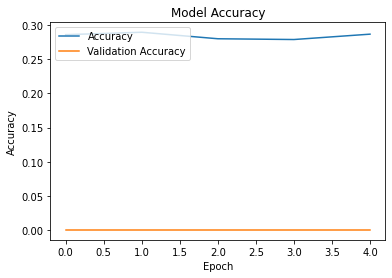

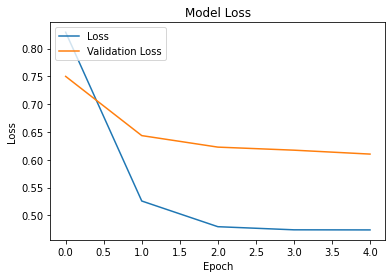

In [ ]:
main.train()
# main.test()

# K-Fold

In [ ]:
# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
acc_per_fold, loss_per_fold = [], []

# K-fold Cross Validation model evaluation
fold_no = 1
print("Start K-fold Cross Validation model evaluation:", datetime.now())
for train, test in kfold.split(inputs, targets):

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  ## Params
  BATCH_SIZE = 32
  EPOCH_COUNT = 10
  FILE_NAME = "train_kfolds5_cnngru_1"

  ## Main
  model = MODEL()
  history, model = model.training_model(x_train, y_train,x_test, y_test, len_data, depth_data, BATCH_SIZE, EPOCH_COUNT, FILE_NAME)

  # Generate generalization metrics
  scores = model.evaluate(x_test, y_test, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
print("Finish K-fold Cross Validation model evaluation:", datetime.now())


Start K-fold Cross Validation model evaluation: 2022-06-28 11:04:18.162154
------------------------------------------------------------------------
Training for fold 1 ...
Building model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 203, 1)]     0           []                               
                                                                                                  
 conv_1 (Conv1D)                (None, 201, 64)      256         ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 201, 64)     256         ['conv_1[0][0]']                 
 alization)                                                                                       
   